

*   SPH(Smoothed Particle Hydrodynamics)風に計算効率の向上をめざした
*   基本的にはランダムウォークみたいな感じ．
*   目的は，衝突判定を入れてアユにシミュレーションレベルの難易度のプログラムを書くこと
*   粒子の動きのルールをあとで差し替えれば，ある程度実用に耐えるのではと．



In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import numpy.random as rnd
import random as random
import math
from statistics import mean,median,variance,stdev
from IPython.display import HTML

rnd.seed(seed=123456789)
N=6000 # 粒子数
TIME=200 # 繰返し回数
K2=0.1 # 速さのペナルティ係数
RADIUS=1.0 # 粒子の半径．xy座標と同じ単位．てきとう
PROB_INFECT=0.3 # 接触時に移る確率
PROB_RECOV=0.01 # 自然に治る確率
MESH_MAX_INDEX=50
MESH_MIN_INDEX=-50

In [0]:
def plot(x,y,color):
    plt.xlim(MESH_MIN_INDEX,MESH_MAX_INDEX)
    plt.ylim(MESH_MIN_INDEX,MESH_MAX_INDEX)
    return plt.scatter(x,y,alpha=0.3,color=color)

In [0]:
class particle:
    id_max=0
    allParticle={}
    mesh={}

    def __init__(self,x,y):
        self.x=x
        self.y=y
        self.id=particle.id_max
        particle.id_max+=1
        self.distFromO=np.sqrt(x**2+y**2)
        self.flag=""
    
    @classmethod
    def synthesizeParticles(cls):
        cls.mesh={x:{y:cell() for y in range(-50,51)} for x in range(-50,51)}
        cls.allParticles={}
        for x,y in zip(rnd.normal(0,25,size=N),rnd.normal(0,25,size=N)):
            #はみだしたら乱数引き直し
            tmpy=y
            tmpx=x
            while(not(MESH_MIN_INDEX<=math.floor(tmpy) and math.floor(tmpy)<=MESH_MAX_INDEX)):
                tmpy=rnd.normal(0,25,1)
            while(not(MESH_MIN_INDEX<=math.floor(tmpx) and math.floor(tmpx)<=MESH_MAX_INDEX)):
                tmpx=rnd.normal(0,25,1)
            ptmp=particle(tmpx,tmpy)
            cls.mesh[math.floor(ptmp.x)][math.floor(ptmp.y)].push(ptmp)
            cls.allParticles[ptmp.id]=ptmp
            print(ptmp.id, ptmp)
        return cls.allParticles, cls.mesh

class cell:
    def __init__(self,particles=[]):#particlesはparticleのリスト
        self.ps=dict(zip([ptmp.id for ptmp in particles],particles))
    def push(self, particle):
        self.ps[particle.id]=particle
        return particle.id
    def pop(self, id):
        return self.ps.pop(id)

In [4]:
allP, mesh=particle.synthesizeParticles()
print(len(allP),len(mesh))
for id in allP.keys():
    if(id >= 10):
        allP[id].flag="S"
    else:
        allP[id].flag="I"

#各時間の数(すべて0で初期化)
#numOf={ "S": [0 for i in range(TIME)], # # of S
#       "I": [0 for i in range(TIME)], # # of I
#        "R": [0 for i in range(TIME)]} # # of R
numOf={}
numOf["S"]=[]
numOf["I"]=[]
numOf["R"]=[]
#print(0,": SIR=",numOf["S"][0],numOf["I"][0],numOf["R"][0])

distFromO={}

for t in range(0,TIME):
    tmpx=[]
    tmpy=[]
    tmpdistFromO=[]
    
    numOf["S"].append(len([1 for v in allP.values() if v.flag=="S"]))
    numOf["I"].append(len([1 for v in allP.values() if v.flag=="I"]))
    numOf["R"].append(len([1 for v in allP.values() if v.flag=="R"]))
    print(t,": SIR=",numOf["S"][t],numOf["I"][t],numOf["R"][t])

    for x,xline in mesh.items():
        #print("x,xline",x,xline)
        for y,c in xline.items(): #セルcについて
            #print("y,c.ps.items()",y,c.ps.items())
            for i, p1 in c.ps.copy().items():#粒子p1について

                #接触判定
                #周囲9メッシュ分の粒子を統合->plist2
                plist2=mesh[x][y].ps.copy()
                if(MESH_MIN_INDEX+1<=y):
                    if(MESH_MIN_INDEX+1<=x): plist2.update(mesh[x-1][y-1].ps.copy())
                    plist2.update(mesh[x][y-1].ps.copy())
                    if(x<=MESH_MAX_INDEX-1): plist2.update(mesh[x+1][y-1].ps.copy())
                if(y<=MESH_MAX_INDEX-1):
                    if(MESH_MIN_INDEX+1<=x): plist2.update(mesh[x-1][y+1].ps.copy())
                    plist2.update(mesh[x][y+1].ps.copy())
                    if(x<=MESH_MAX_INDEX-1): plist2.update(mesh[x+1][y+1].ps.copy())
                #print("plist2.items()",plist2.items())
                #print("type(p1)",type(p1))
                #print("type(p2)",type(p2))
                #print("p1",p1.x,p1.y)
                #print("p2",p2.x,p2.y)
                for j, p2 in plist2.items(): #粒子p2について
                    if(p1 is not p2):
                        if((p1.flag=="I" and p2.flag=="S") or (p1.flag=="S" and p2.flag=="I")):
                            if(rnd.rand()<PROB_INFECT):
                                d=math.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
                                #print(t,p1.x,p1.y,p2.x,p2.y,d,"HIT!!")
                                if(d<RADIUS):
                                    #print(t,p1.x,p1.y,p2.x,p2.y,d,"NEW INFECTION!")
                                    p1.flag="I"
                                    p2.flag="I"
                                    numOf["S"][t]+=-1
                                    numOf["I"][t]+=+1
                #移動量dx,dy
                mesh[math.floor(p1.x)][math.floor(p1.y)].pop(p1.id)
                dx = rnd.randn(1) #速度(単位時間当たりの移動)=標準正規分布乱数-なんか速度に比例する抵抗力
                dy = rnd.randn(1)
                dx = dx - dx*K2
                dy = dy - dy*K2
                p1.x += dx
                p1.y += dy
                ##TODO メッシュ間の移動
                #範囲外に出たらてきとうに初期状態同様にぶっ飛ばす
                while(not(MESH_MIN_INDEX<=math.floor(p1.y) and math.floor(p1.y)<=MESH_MAX_INDEX)):
                    p1.y=rnd.normal(0,25,1)
                while(not(MESH_MIN_INDEX<=math.floor(p1.x) and math.floor(p1.x)<=MESH_MAX_INDEX)):
                    p1.x=rnd.normal(0,25,1)
                tmpdistFromO.append(math.sqrt(p1.x[-1]**2+p1.x[-1]**2))

                mesh[math.floor(p1.x)][math.floor(p1.y)].push(p1)

                #recover
                if(p1.flag=="I" and rnd.rand()<PROB_RECOV):
                    p1.flag="R"
                    #print(t,p1.x,p1.y,"NEW RECOVER!")
                    numOf["I"][t]+=-1
                    numOf["R"][t]+=+1

            distFromO[t]=tmpdistFromO
    print(t,": SIR=",numOf["S"][t],numOf["I"][t],numOf["R"][t])


ストリーミング出力は最後の 5000 行に切り捨てられました。
1402 <__main__.particle object at 0x7f8111d310b8>
1403 <__main__.particle object at 0x7f8111d31128>
1404 <__main__.particle object at 0x7f8111d31198>
1405 <__main__.particle object at 0x7f8111d31208>
1406 <__main__.particle object at 0x7f8111d31278>
1407 <__main__.particle object at 0x7f8111d312e8>
1408 <__main__.particle object at 0x7f8111d31358>
1409 <__main__.particle object at 0x7f8111d313c8>
1410 <__main__.particle object at 0x7f8111d31438>
1411 <__main__.particle object at 0x7f8111d314a8>
1412 <__main__.particle object at 0x7f8111d31518>
1413 <__main__.particle object at 0x7f8111d31588>
1414 <__main__.particle object at 0x7f8111d315f8>
1415 <__main__.particle object at 0x7f8111d31668>
1416 <__main__.particle object at 0x7f8111d316d8>
1417 <__main__.particle object at 0x7f8111d31748>
1418 <__main__.particle object at 0x7f8111d31780>
1419 <__main__.particle object at 0x7f8111d317f0>
1420 <__main__.particle object at 0x7f8111d31860>
1421 <__main__.par

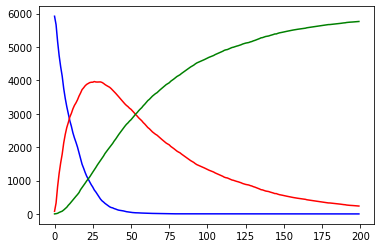

In [5]:
plt.plot(range(len(numOf["S"])),numOf["S"],color='b')
plt.plot(range(len(numOf["I"])),numOf["I"],color='r')
plt.plot(range(len(numOf["R"])),numOf["R"],color='g')


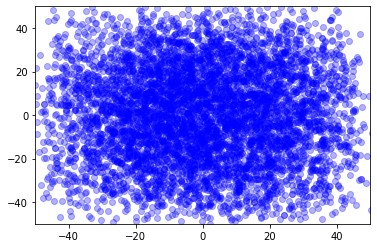

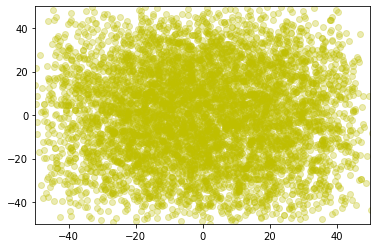

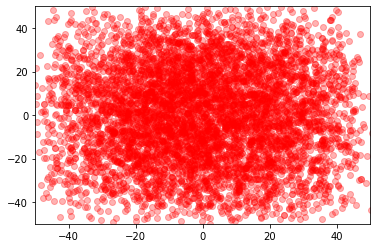

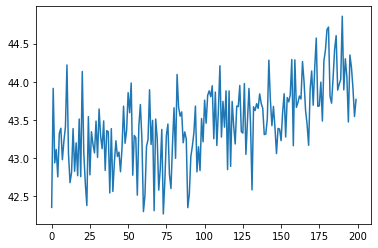

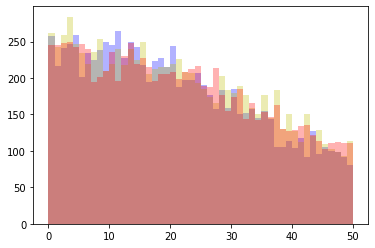

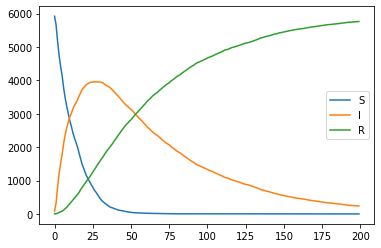

In [6]:
# 2次元平面上の粒子の位置(t=0,TIME/2,TIME)
plt.xlim(-MESH_MAX_INDEX,MESH_MAX_INDEX)
plt.ylim(-MESH_MAX_INDEX,MESH_MAX_INDEX)
plot([p.x for p in allP.values()],[p.y for p in allP.values()],color='b')
plt.show()
plot([p.x for p in allP.values()],[p.y for p in allP.values()],color='y')
plt.show()
plot([p.x for p in allP.values()],[p.y for p in allP.values()],color='r')
plt.show()

#anime?
#fig, ax = plt.subplots()
#plt.close()
#plots=[]
#for t in range(0,TIME,10):
#    p =ax.plot(px[t],py[t],alpha=0.3,color='b')
#    plots.append(p)
#ani = animation.ArtistAnimation(fig, plots, interval=100, blit=True)# 100ms ごとに表示
#rc('animation', html='jshtml')
#ani

# 中心からの距離の時間変化
m=[sum(distFromO[t])/N for t in range(TIME)]
plt.plot(m)
plt.show()

# t=0,TIME/2,TIMEのときの2次元平面の中央からの距離(ヒストグラム)
plt.hist(distFromO[0],bins=50,range=(0,50),alpha=0.3,color='b')
plt.hist(distFromO[TIME//2],bins=50,range=(0,50),alpha=0.3,color='y')
plt.hist(distFromO[TIME-1],bins=50,range=(0,50),alpha=0.3,color='r')
plt.show()


plt.plot(numOf["S"],label="S")
plt.plot(numOf["I"],label="I")
plt.plot(numOf["R"],label="R")
plt.legend()
plt.show()